In [1036]:
import warnings
warnings.filterwarnings ( "ignore" )
import os
from time import time
from datetime import datetime,timedelta  #time,
import matplotlib.pyplot as plt
import multiprocess as mp
from IPython.display import display


# Scientific and data
import json
import numpy as np
from tqdm import tqdm
import pandas as pd
import  xarray as xr
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.interpolate import griddata
from functools import partial
eps = np.finfo(np.float).eps
from scipy.stats import multivariate_normal

# pytorch
import torch , torchvision
import torch.utils.data
import torch.nn as nn
from torch import functional as F
from torch import Tensor
torch.manual_seed(8318)
from sklearn.model_selection import train_test_split


# Local modules
import  global_settings as gs
import data_loader as dl
import preprocessing as prep
from utils import create_and_configer_logger
from miscLidar import calc_extiction_klett
# %%
def angstrom(tau_1,tau_2, lambda_1,lambda_2):
	"""
	calculates angstrom exponent
	:param tau_1: AOD Aerosol optical depth at wavelength lambda_1
	:param tau_2: AOD Aerosol optical depth at wavelength lambda_2
	:param lambda_1: wavelength lambda_1 , lambda_1<lambda_2 (e.g. 355 nm)
	:param lambda_2: wavelength lambda_2 , lambda_1<lambda_2 (e.g. 532 nm)
	:return: angstrom exponent A_1,2
	"""
	return -np.log(tau_1/tau_2)/np.log(lambda_1/lambda_2)

In [871]:
total_time_bins = 2880
dr = 7.4714e-3
top_height = 10 #km
total_height_bins = np.int(top_height/dr)
x = np.arange(total_time_bins)
y = np.arange(total_height_bins)

X, Y = np.mgrid[0:total_time_bins:1, 0:total_height_bins:1]
grid = np.dstack((X, Y))
grid.shape

(2880, 1338, 2)

In [874]:
X, Y = np.meshgrid(x,y,indexing = 'xy')
grid = np.dstack((X, Y))
grid.shape

(1338, 2880, 2)

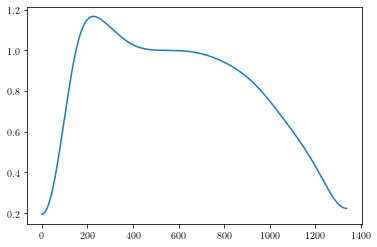

In [697]:
t = np.array([0,0.05,0.1,.3,.5,.6,.7,.8,.9,1.0])*np.float(total_height_bins)
ratios = np.array([.0,.1,1.3,1,1,.95,0.85,0.65,.45,0.1])
t_interp = np.arange(start = 1,stop=total_height_bins+1,step=1)
ratio_interp= np.interp(t_interp,t,ratios)
plt.figure()
plt.plot(t_interp,gaussian_filter1d(ratio_interp, sigma=60))
plt.show()

In [865]:
def get_random_sample_grid(nx,ny,orig_x, orig_y,std_ratio=.125):
	delta_x = (orig_x[-1]-orig_x[0])/nx
	delta_y = (orig_y[-1]-orig_y[0])/ny

	# generate a new grid (points are set to be in the middle of each patch)
	center_x = .5*delta_x + (np.arange(nx)*delta_x).astype(int).reshape((1,nx)).repeat(ny,axis=0) + orig_x[0]
	center_y = .5*delta_y + (np.arange(ny)*delta_y).astype(int).reshape((ny,1)).repeat(nx,axis=1) + orig_y[0]

	# set random distances from centers of the new grid
	dx = (std_ratio*delta_x*np.random.randn(nx,ny)).astype(int).T
	dy = (std_ratio*delta_y*np.random.randn(nx,ny)).astype(int).T

	# set random point in each patch of the new grid
	points_x = center_x + dx
	points_y = center_y + dy

	new_grid = {'x': center_x.flatten(),'y':center_y.flatten()}
	sample_points = {'x': points_x.flatten(),'y':points_y.flatten()}
	return  new_grid,sample_points

def get_random_cov_mat(lbound_x = .5 , lbound_y=.1):
	# generating covariance matrix with higher x diagonal of gaussian
	# set : lbound_x< std_x <= 1
	std_x = 1 - lbound_x*np.random.rand()
	# set : lbound_y < std_y <= std_x
	std_y = std_x - (std_x-lbound_y)*np.random.rand()
	# %%
	# generate random correlation [-1,1]
	# this is to make sure that the covariance matrix is PSD : std_x*std_y - std_xy*std_xy >= 0
	rho = -1 + 2*np.random.rand()
	std_xy = rho*std_y*std_x
	cov = np.array([[std_x,std_xy],[std_xy,std_y]])
	return cov

def make_interpolated_image(nsamples,im):
    """Make an interpolated image from a random selection of pixels.

    Take nsamples random pixels from im and reconstruct the image using
    scipy.interpolate.griddata.

    """
    nx, ny = im.shape[1], im.shape[0]
    X, Y = np.meshgrid(np.arange(0, nx, 1), np.arange(0, ny, 1))
    ix = np.random.randint(im.shape[1], size=nsamples)
    iy = np.random.randint(im.shape[0], size=nsamples)
    samples = im[iy,ix]
    int_im = griddata((iy, ix), samples, (Y, X),method = 'nearest',fill_value = 0)
    return int_im

In [880]:
def create_gaussians_level(grid,nx,ny,grid_x,grid_y,std_ratio=.125,choose_ratio = 1.0,
                           cov_size = 1E-5, cov_r_lbounds=[.8,.1]):

	# create centers of Gaussians:
	new_grid,sample_points = get_random_sample_grid(nx,ny,grid_x,grid_y,std_ratio)
	if choose_ratio<1.0:
		center_x, _, center_y, _ = train_test_split(sample_points['x'],sample_points['y'],
		                                                    train_size = choose_ratio,shuffle = True)
	else:
		center_x = sample_points['x']
		center_y = sample_points['y']

	# Create covariance to each gaussian and adding each
	grid_ratio = 1
	Z_level = np.zeros((grid.shape[0],grid.shape[1]))
	for x0,y0 in zip(center_x,center_y):
		cov = cov_size*get_random_cov_mat(lbound_x = cov_r_lbounds[0] , lbound_y=cov_r_lbounds[1])
		rv = multivariate_normal((x0,y0), cov)
		Z_level += grid_ratio*rv.pdf(grid)
	# normalizing:
	Z_level = (Z_level - Z_level.min())/(Z_level.max() - Z_level.min())
	return Z_level

In [881]:
nx =5
ny = 1
grid_ratio = 1.0
cov_size =1E+6
choose_ratio = .95
std_ratio = .25
cov_r_lbounds=[.8,.1]
Z_level0 = create_gaussians_level(grid,nx,ny,x,y[ 0:int(0.5*total_height_bins)],std_ratio,
                                  choose_ratio,cov_size,cov_r_lbounds)

plt.figure()
im = plt.imshow(Z_level0,cmap = 'turbo')
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

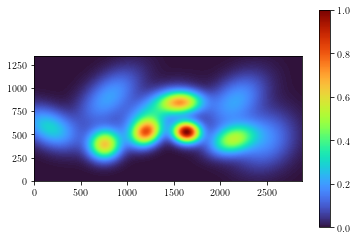

In [893]:
nx = 6
ny = 2
grid_ratio = 1.0
cov_size = 5*1E+4
choose_ratio = .9
std_ratio = .15
cov_r_lbounds=[.8,.1]
Z_level1 = create_gaussians_level(grid,nx,ny,x,y[ int(0.2*total_height_bins):int(0.8*total_height_bins)],std_ratio,
                                  choose_ratio,cov_size,cov_r_lbounds)

plt.figure()
im = plt.imshow(Z_level1,cmap='turbo')
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

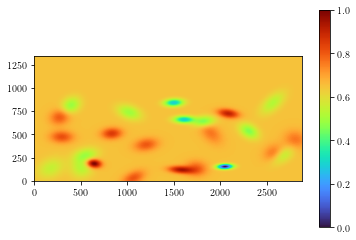

In [904]:
nx = 9
ny = 1
new_grid,sample_points = get_random_sample_grid(nx,ny,x, y[int(0*total_height_bins):int(.3*total_height_bins)],
                                                std_ratio=.25)
center_x = sample_points['x']
center_y = sample_points['y']

nx = 8
ny = 1
new_grid,sample_points = get_random_sample_grid(nx,ny,x,  y[int(.2*total_height_bins):int(.5*total_height_bins)],
                                                std_ratio=.25)
center_x1 = sample_points['x']
center_y1 = sample_points['y']

nx = 7
ny = 1
new_grid,sample_points = get_random_sample_grid(nx,ny,x, y[int(.4*total_height_bins):int(0.7*total_height_bins)],
                                                std_ratio=.25)
center_x2 = sample_points['x']
center_y2= sample_points['y']

# %%
center_x_split_1, center_x_split_2, center_y_split_1, center_y_split_2 =\
	train_test_split(np.concatenate((center_x, center_x1,center_x2),axis = 0),
	                 np.concatenate((center_y, center_y1,center_y2),axis = 0),
	                 train_size = .5)

grid_cov_size = 1E+4
Z_level2 = np.zeros((grid.shape[0],grid.shape[1]))
for x0,y0 in zip(center_x_split_1,center_y_split_1):
	cov = grid_cov_size*get_random_cov_mat(lbound_x = .7 , lbound_y=.01)
	rv = multivariate_normal((x0,y0), cov)
	r = 1#ratio_interp[int(y0)]
	Z_level2 += r*grid_ratio*rv.pdf(grid)
for x0,y0 in zip(center_x_split_2,center_y_split_2):
	cov = grid_cov_size*get_random_cov_mat(lbound_x = .7 , lbound_y=.01)
	rv = multivariate_normal((x0,y0), cov)
	r = -1 #ratio_interp[int(y0)]
	Z_level2 += r*grid_ratio*rv.pdf(grid)

Z_level2 = (Z_level2 -Z_level2.min())/(Z_level2.max()-Z_level2.min())
plt.figure()
im = plt.imshow(Z_level2,cmap = 'turbo')
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

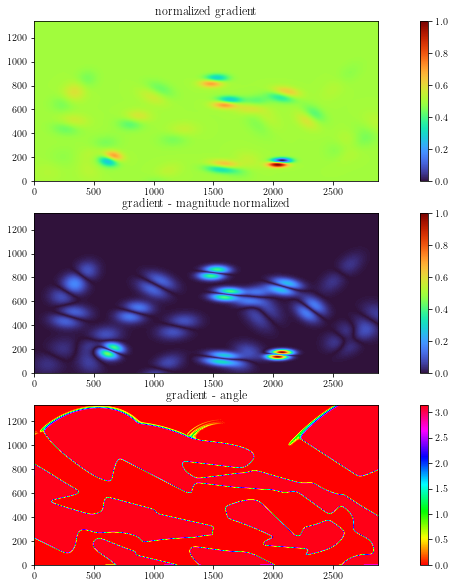

In [905]:
import cv2 as cv
from scipy import signal
g_filter = np.array([[0 , -1, 0],
                     [-1, 0 , 1],
                     [0 , 1 , 0]])
grad = signal.convolve2d(Z_level2, g_filter, boundary='symm', mode='same')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
ax = axes.ravel()
ax_i = ax[0]
grad_norm = (grad-grad.min())/(grad.max()-grad.min())
im = ax_i.imshow(grad_norm, cmap='turbo')
plt.colorbar(im, ax=ax_i)
ax_i.set_aspect('equal')
ax_i.invert_yaxis()
ax_i.set_title('normalized gradient')

ax_i= ax[1]
grad_amplitude = np.absolute(grad)
grad_norm_amplitude= (grad_amplitude-grad_amplitude.min())/(grad_amplitude.max()-grad_amplitude.min())
im = ax_i.imshow(grad_norm_amplitude, cmap='turbo')
plt.colorbar(im, ax=ax_i)
ax_i.set_aspect('equal')
ax_i.invert_yaxis()
ax_i.set_title('gradient - magnitude normalized')

ax_i= ax[2]
im = ax_i.imshow(np.angle(grad), cmap='hsv')
plt.colorbar(im, ax=ax_i)
ax_i.set_aspect('equal')
ax_i.invert_yaxis()
ax_i.set_title('gradient - angle')
plt.show()

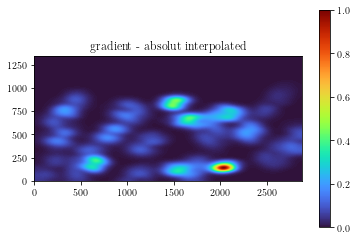

In [932]:
nsamples= int(total_height_bins*total_time_bins *.0005)
interp_features = make_interpolated_image(nsamples,grad_norm_amplitude)
blur_features= gaussian_filter(interp_features,sigma=(21,61))
blur_features = (blur_features-blur_features.min())/(blur_features.max()-blur_features.min())
plt.figure()
im = plt.imshow(blur_features, cmap='turbo')
plt.colorbar(im)
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.title('gradient - absolut interpolated')
plt.show()

In [929]:
indexes= np.round(np.linspace(0,720,97)).astype(int)
target_indexes = [ i*30 for i in range(97)]
target_indexes[-1]-=1
start_t = datetime(2017,9,1,0,0)
end_t = start_t+timedelta(hours = 24)-timedelta(seconds = 30)
target_time_index = pd.date_range(start = start_t,end = end_t,freq = '30S')
tt_index = target_time_index[target_indexes]

In [939]:
def get_sub_sample_level (level, source_indexes, target_indexes):
	z_samples = level[:,source_indexes]
	df_sigma= pd.DataFrame(z_samples,columns = target_indexes)
	interp_sigma_df = (df_sigma.T.resample( '30S' ).interpolate ( method = 'linear' )).T
	sampled_interp = interp_sigma_df.values
	sampled_interp=(sampled_interp-sampled_interp.min())/(sampled_interp.max()-sampled_interp.min())
	return sampled_interp

## The 3 levels of aerosol density

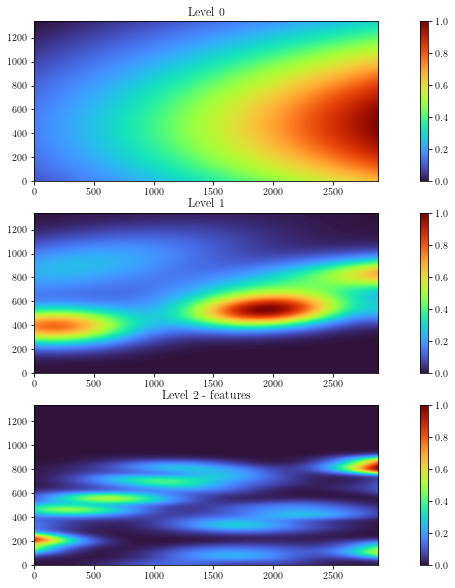

In [1012]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))
ax =axes.ravel()
# %%
source_indexes = indexes#+int(720*1-1)
sampled_level0_interp  = get_sub_sample_level (Z_level0, source_indexes, tt_index)
# %%
source_indexes = indexes+720*1-1
sampled_level1_interp  = get_sub_sample_level (Z_level1, source_indexes, tt_index)
# %%
source_indexes = indexes+720*1-1
sampled_level2_interp  = get_sub_sample_level (blur_features, source_indexes, tt_index)
#sampled_level2_interp = sampled_level2_interp*2-1
# %%

ax_i = ax[0]
im = ax_i.imshow(sampled_level0_interp,cmap = 'turbo')
plt.colorbar(im,ax = ax_i)
ax_i.set_title('Level 0')
ax_i.set_aspect('equal')
ax_i.invert_yaxis()

ax_i = ax[1]
im = ax_i.imshow(sampled_level1_interp,cmap = 'turbo')
plt.colorbar(im,ax = ax_i)
ax_i.set_title('Level 1')
ax_i.set_aspect('equal')
ax_i.invert_yaxis()

ax_i = ax[2]
im = ax_i.imshow(sampled_level2_interp,cmap = 'turbo')
plt.colorbar(im,ax = ax_i)
ax_i.set_title('Level 2 - features')
ax_i.set_aspect('equal')
ax_i.invert_yaxis()

plt.show()

## Profiles at different times

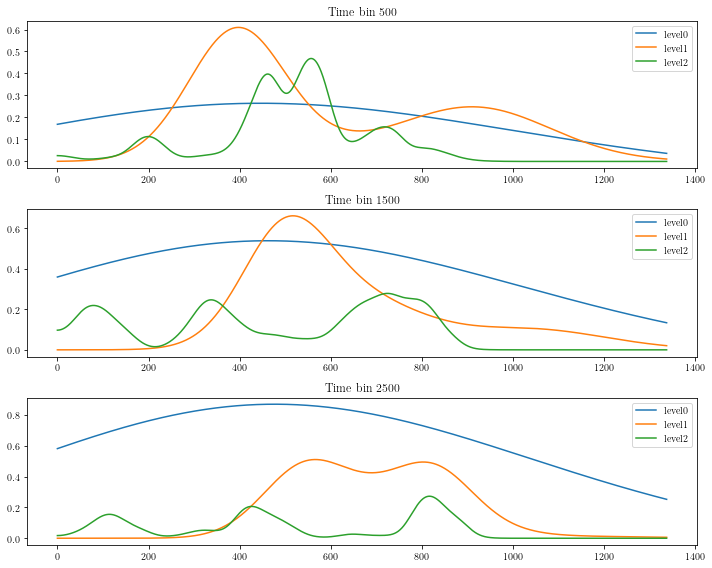

In [1021]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,8))
t_index = [500,1500,2500]
for t_ind,ax in zip(t_index,axes.ravel()):
	ax.plot(sampled_level0_interp[:,t_ind],label='level0')
	ax.plot(sampled_level1_interp[:,t_ind],label='level1')
	ax.plot(sampled_level2_interp[:,t_ind],label='level2')
	ax.set_title(f"Time bin {t_ind}")
	ax.legend()
plt.tight_layout()
plt.show()

## Merged density level
#### Built as a linear combination of the levels above

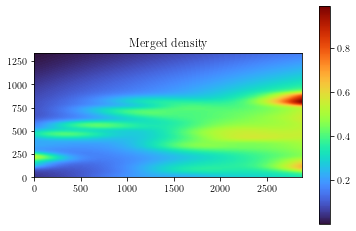

In [1066]:
#Z_new = .8*sampled_level0_interp+.4*sampled_level1_interp+.2*sampled_level2_interp
Z_new = 0.5*sampled_level0_interp + .5*sampled_level2_interp + 0.1*sampled_level1_interp

#Z_new = (Z_new-Z_new.min())/(Z_new.max()-Z_new.min())
plt.figure()
im = plt.imshow(Z_new,cmap = 'turbo')
plt.colorbar(im)
plt.title('Merged density')
plt.gca().set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

## Merged aerosol level at $\lambda=532[nm]$
#### To create the aerosol, the density is:
1. Normalized
2. Corrected according to ratio above
3. multiplied with a typical $\sigma_{aer,532}$, e.g. $\sigma_{max}=0.035[1/km]$

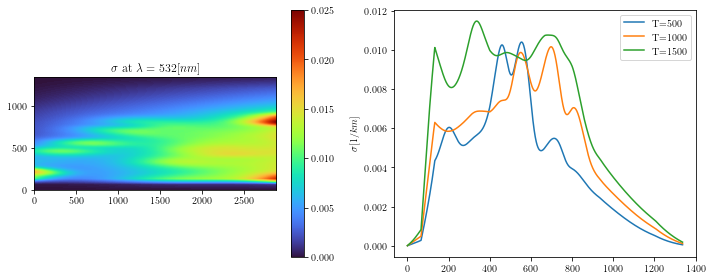

In [1069]:
# max value of attenuation backscatter
max_val =.025 #0.012
im_ratio = ratio_interp.reshape((total_height_bins,1)).repeat(total_time_bins,axis=1)
Z_ratio = Z_new*im_ratio
Z_norm = max_val*(Z_ratio-Z_ratio.min())/(Z_ratio.max()-Z_ratio.min())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax = axes.ravel()
#plt.figure()
im = ax[0].imshow(Z_norm,cmap = 'turbo')
plt.colorbar(im,ax=ax[0])
ax[0].set_title(r'$\sigma$ at $\lambda=532[nm]$')
ax[0].invert_yaxis()

for t_bin in [500,1000,1500]:
	ax[1].plot(Z_norm[:,t_bin],label = f"T={t_bin}")
ax[1].legend()
ax[1].set_ylabel(r'$\sigma [1/km]$')
plt.tight_layout()
plt.show()

## Calculate Aearosol Optical Depth (AOD)
## $\tau_{aer,\lambda} = \int \sigma_{aer,\lambda} (r) dr\;\; \forall \, r \leq r_{ref} $

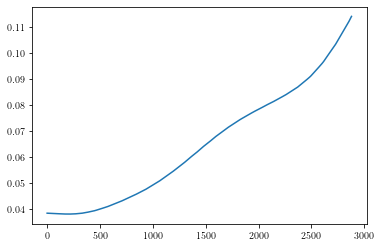

In [1071]:
AOD = Z_norm.sum(axis=0)*dr
plt.figure()
plt.plot(AOD)
plt.show()

## Angstrom Exponent
to convert $\sigma_{er}$ from $532[nm]$ to $355[nm]$ and $1064[nm]$

In [ ]:
angstrom(0.45,.31, 355,532)

angstrom(0.32,.15, 532,1064)